In [2]:
!pip install catboost

     |████████████████████████████████| 66.1MB 42kB/s 


In [16]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")
import re

In [4]:
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")

In [5]:
full_df=pd.concat([train,test],axis=0).reset_index(drop=True)

In [6]:
#full_df['Product_Description']=full_df['Product_Description'].apply(lambda x:re.sub(r"\W+",' ',x))
full_df['length']=full_df['Product_Description'].apply(lambda x:len(re.findall(r"\w+",x)))
m=full_df.groupby('Product_Type')['length'].agg(['mean','max','min'])
full_df=full_df.merge(m,on='Product_Type',how='left')

In [7]:
full_df.head()

,Text_ID,Product_Description,Product_Type,Sentiment,length,mean,max,min
0,3057,The Web DesignerÛªs Guide to iOS (and Android...,9,2.0,17,18.126013,41,2
1,6254,RT @mention Line for iPad 2 is longer today th...,9,2.0,22,18.126013,41,2
2,8212,Crazy that Apple is opening a temporary store ...,9,2.0,20,18.126013,41,2
3,4422,The lesson from Google One Pass: In this digit...,9,2.0,22,18.126013,41,2
4,5526,RT @mention At the panel: &quot;Your mom has a...,9,2.0,16,18.126013,41,2


In [8]:
!pip install transformers
!pip install -U sentence-transformers

     |████████████████████████████████| 890kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 15.0MB/s 
     |████████████████████████████████| 890kB 18.2MB/s 
     |████████████████████████████████| 3.0MB 21.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ba85f24b1784f88f9c0519f972818ab559191f0d73b8fc5363359bf99af243da
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 71kB 2.2MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.6-cp36-none-any.whl size=101182 sha256=767e8c05536e3ecf0ac60889c74f613a9cf9d537d15814995cd867ad38ab1a63
  Stored in directory: /root/.cache/pip/wheels/6f/3f/75/c0c4b3ef5dfbf8806d37b8dc661861772aba2f7aa419c85a9b
Successfully built sentence-transformers


In [9]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import tokenizers
print('TF version',tf.__version__)

TF version 2.3.0


# **Roberta Large Model**

In [10]:
from sentence_transformers import SentenceTransformer
sentence_embedder = SentenceTransformer('roberta-large-nli-stsb-mean-tokens')

100%|██████████| 1.31G/1.31G [01:55<00:00, 11.4MB/s]


In [11]:
%%time
sentence_embeddings = sentence_embedder.encode(full_df.Product_Description.values.tolist(),batch_size=64,show_progress_bar=True)


CPU times: user 30.7 s, sys: 15.5 s, total: 46.2 s
Wall time: 52.1 s


In [12]:
data = pd.DataFrame(sentence_embeddings)
for i in ["Product_Type","Sentiment","length","mean","max","min"]:
  data[i] = full_df[i].values
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023,Product_Type,Sentiment,length,mean,max,min
0,0.330165,-0.247397,-0.870642,0.005058,0.354620,-0.836421,1.249181,-0.627187,-0.034642,-0.239110,0.474412,-1.271331,-0.416535,0.245359,-0.990853,0.118077,-0.088616,0.332720,-0.189814,0.052836,-0.358442,-1.129598,-1.480089,0.960928,0.202038,1.771792,1.036318,-1.168895,-0.092231,-0.332392,-0.727229,1.432422,-0.914551,0.855940,-0.750450,-0.466039,0.084275,-1.321737,0.246428,-0.685505,...,0.743919,0.187946,0.056851,-0.372119,0.295995,-0.707240,-1.057208,-0.606955,0.074582,-0.230364,-0.240018,1.797071,-1.269070,-0.876562,-0.449873,-1.003565,-0.593831,-0.968504,1.194811,0.173917,-0.902885,-1.918223,-0.287934,0.338151,-1.320299,-1.120231,-0.587946,-0.453286,0.274506,0.553715,0.256694,-0.069876,-0.509241,-1.558362,9,2.0,17,18.126013,41,2
1,0.278989,0.330941,-0.165491,-1.635586,0.687117,-0.535727,0.614250,1.429139,-0.475145,0.670293,-0.328978,0.634183,-0.217570,-0.002113,-0.577375,0.345339,0.807565,1.143098,1.049115,-0.005919,0.444396,-2.222993,0.773282,0.783117,0.237505,0.096515,-0.506388,-0.435858,0.655360,0.001264,-1.252077,0.544314,-0.423391,-0.367903,-1.926222,0.767378,-2.255352,-0.418795,-0.075096,-0.679808,...,-0.453680,-1.408923,0.569647,1.062356,-0.229778,0.375595,0.009395,-0.098088,0.936759,0.275842,-0.804953,-0.857161,-2.376615,0.742030,0.466317,-1.231065,-1.222435,-0.363849,-0.511013,-0.013213,-0.533763,-2.542952,-0.107766,-0.374117,-0.254659,0.653225,0.864038,0.895205,1.169006,0.596770,0.461121,-0.165451,-0.091080,-0.331924,9,2.0,22,18.126013,41,2
2,0.054071,0.683320,-0.719468,-0.993364,0.146501,-1.322316,0.569946,0.273334,0.294247,-0.616734,0.041258,-0.348921,0.146179,0.279477,-2.329789,0.841442,0.808261,0.518159,0.378362,-0.352653,0.894693,-0.749424,0.046378,0.433437,-0.055451,0.867230,-0.472142,0.023805,0.485383,0.047716,-0.218020,0.998918,-0.150348,-0.102221,-1.301127,-0.192057,-0.534871,-0.740003,0.566584,-1.096631,...,-1.146204,0.086847,-0.393993,-0.126912,0.996776,-1.153902,-0.766382,-0.377434,0.723442,0.191847,-0.814166,-1.085052,-1.658119,-0.498427,-0.452110,-2.083881,-0.777529,-1.643397,0.891261,0.315838,-0.626215,-0.960399,-0.703349,-0.219069,-0.047881,-0.796186,0.478782,0.991951,0.238711,0.564170,0.152122,-0.402951,-1.189984,0.525129,9,2.0,20,18.126013,41,2
3,-1.283736,1.077794,0.115693,-0.754599,-0.353901,0.099093,0.026904,-1.588506,-0.343078,0.776587,0.609058,-1.232810,-0.395967,1.201138,0.514959,-1.009338,0.468748,-0.771186,0.470583,0.265297,-0.536604,-1.432280,-0.155619,-0.208997,0.023684,0.743148,-0.802505,-0.559221,-0.890675,-0.530240,-0.387051,0.228818,-0.881575,0.404648,-0.383866,0.167418,0.385697,-1.069829,-0.677940,-0.791103,...,-0.039768,0.424859,-0.052332,-0.475321,2.061460,-0.723258,-1.593484,0.001796,0.298123,0.493564,-0.735725,-1.200398,-0.975538,0.123734,-0.091106,-1.905183,-0.579613,-1.124421,1.478265,-0.436936,-0.394281,-1.356696,-1.036585,0.999023,-0.608468,-0.067053,-0.116878,0.798799,0.617623,0.398502,-0.310564,0.483582,-0.040487,-0.366792,9,2.0,22,18.126013,41,2
4,-0.685147,0.356008,-0.141168,-0.743663,-0.430732,-0.503180,-0.009455,-0.170719,-0.768279,0.383436,-0.045505,-0.437405,0.072291,-0.533039,0.044454,-1.127246,0.013488,0.391307,1.493541,1.116441,-0.713018,-0.380920,0.693903,0.676983,-0.356788,-0.496086,0.489434,-1.643811,-0.468427,-0.708996,-0.463611,1.014461,0.284167,0.857794,-0.694770,-2.135303,1.083803,-0.472779,-0.645185,-0.088481,...,0.458621,-1.409883,0.815893,-1.152876,0.937024,-0.232832,-0.673952,-1.275878,-0.651407,0.106804,0.852991,-0.961393,-2.609520,1.181577,-0.190355,-0.792485,0.025200,0.082749,0.371371,0.144736,-0.636164,-0.750758,0.167548,0.452039,-0.660471,0.731407,-0.638428,2.368103,0.084374,1.719391,-0.300217,-0.135863,-1.261115,0.310947,9,2.0,16,18.12

In [13]:
train = data[data.Sentiment.notna()]
test = data[data.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

In [14]:
train.shape,test.shape

((6364, 1030), (2728, 1029))

In [17]:
x_train = train.drop(["Sentiment"],axis=1)
y_train= train[['Sentiment']]

In [20]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

0:	learn: 0.8764486	test: 0.8782404	best: 0.8782404 (0)	total: 28.9ms	remaining: 12m 3s
100:	learn: 0.8970733	test: 0.8868814	best: 0.8884525 (67)	total: 2.18s	remaining: 8m 58s
200:	learn: 0.9041446	test: 0.8908091	best: 0.8908091 (190)	total: 4.24s	remaining: 8m 43s
300:	learn: 0.9070909	test: 0.8931658	best: 0.8931658 (288)	total: 6.28s	remaining: 8m 35s
400:	learn: 0.9121980	test: 0.8931658	best: 0.8931658 (288)	total: 8.3s	remaining: 8m 28s
500:	learn: 0.9155372	test: 0.8931658	best: 0.8931658 (288)	total: 10.3s	remaining: 8m 25s
600:	learn: 0.9167158	test: 0.8931658	best: 0.8939513 (547)	total: 12.3s	remaining: 8m 19s
700:	learn: 0.9198586	test: 0.8939513	best: 0.8939513 (547)	total: 14.3s	remaining: 8m 14s
800:	learn: 0.9259478	test: 0.8947368	best: 0.8947368 (771)	total: 16.2s	remaining: 8m 10s
900:	learn: 0.9292870	test: 0.8947368	best: 0.8947368 (771)	total: 18.3s	remaining: 8m 8s
1000:	learn: 0.9353762	test: 0.8947368	best: 0.8947368 (771)	total: 20.3s	remaining: 8m 5s
1100:

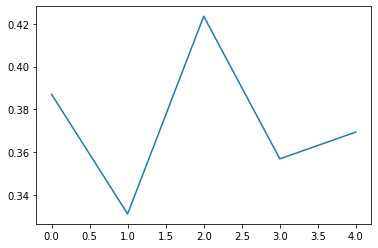

In [21]:
params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0355,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    "boosting_type":"Plain"
}


best_score = np.inf
scores = []

kf=KFold(n_splits=5,shuffle=True,random_state=42)
for train_idx , test_idx in kf.split(x_train,y_train):
  train_set = (x_train.iloc[train_idx],y_train.iloc[train_idx])
  test_set = (x_train.iloc[test_idx],y_train.iloc[test_idx])

  model=CatBoostClassifier(**params)
  model.fit(*train_set,
            cat_features=['Product_Type'],
            eval_set=[test_set],
            early_stopping_rounds=500,
            verbose=100)
  score=log_loss(test_set[1].values,model.predict_proba(test_set[0]))

  print(score)
  scores.append(score)

  if score<best_score:
    best_Score=score
    best_model=model

  print('-'*100)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)

In [23]:
model_large=best_model
m = pd.DataFrame(list(zip(x_train.columns,model_large.feature_importances_))).sort_values(1,ascending=False)
m

,0,1
1024,Product_Type,28.237267
1027,max,8.351636
1028,min,5.007601
655,655,0.969325
84,84,0.701289
...,...,...
641,641,0.000000
339,339,0.000000
981,981,0.000000
250,250,0.000000


In [24]:
submission = pd.DataFrame(model_large.predict_proba(test))
submission.columns = [f'Class_{i}' for i in submission.columns]
submission

,Class_0,Class_1,Class_2,Class_3
0,0.001758,0.017944,0.039057,0.941241
1,0.023661,0.021991,0.926221,0.028128
2,0.010544,0.004370,0.953619,0.031467
3,0.000952,0.011650,0.005955,0.981443
4,0.008517,0.002452,0.961234,0.027797
...,...,...,...,...
2723,0.018568,0.022584,0.930020,0.028827
2724,0.009435,0.003331,0.943129,0.044105
2725,0.001770,0.023081,0.032327,0.942823
2726,0.011527,0.004554,0.956848,0.027072


# **Roberta Base Models**

In [26]:
from sentence_transformers import SentenceTransformer
base_embedder=SentenceTransformer('roberta-base-nli-stsb-mean-tokens')

100%|██████████| 459M/459M [00:41<00:00, 10.9MB/s]


In [27]:
%%time
base_embeddings = base_embedder.encode(full_df.Product_Description.values.tolist(),batch_size=128,show_progress_bar=True)


CPU times: user 10.1 s, sys: 3.4 s, total: 13.5 s
Wall time: 13.5 s


In [29]:
data = pd.DataFrame(base_embeddings)
data['product'] = full_df.Product_Type.values
data['Sentiment'] = full_df.Sentiment.values
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,product,Sentiment
0,-0.213892,-0.078237,0.425070,0.070156,-1.074826,0.550598,-0.037865,-0.941952,-0.268316,-0.193891,-0.715721,-0.916273,0.349077,2.603539,-0.809141,-0.517888,-0.613942,-0.071862,0.649604,0.367172,-0.763611,-0.734709,-1.457823,0.942833,0.230982,-0.227856,0.006733,-0.620646,-0.292909,0.870090,0.007132,0.351150,-0.023495,-1.252404,0.010694,0.275839,1.444032,0.154453,-0.187872,0.398615,...,0.868395,-0.326264,-0.124642,-1.243666,0.085748,1.448836,-0.943065,-0.522150,-0.666419,1.125074,-0.179955,-0.775389,0.708535,0.009818,0.076141,-0.168705,-1.096211,0.979141,-1.188685,0.732397,3.028975,0.011725,-0.001381,0.729547,-0.601280,-0.275464,0.252104,-0.515478,-0.310147,-1.296503,-0.788538,0.141525,0.052002,-0.038399,-0.338132,-0.666649,-0.774718,0.726099,9,2.0
1,0.346898,0.472381,0.174338,0.382898,0.700836,-0.872197,0.105461,-1.294667,0.211178,-0.362303,-0.059532,-0.872606,-0.133363,1.566071,-0.156924,-0.149481,1.586048,0.302141,0.831896,0.184373,-0.863887,-0.985159,0.010297,0.304479,0.733572,-0.502838,1.414683,0.092136,-0.135937,-0.444432,-0.992245,-0.723863,0.307738,-0.396365,1.258619,0.617504,0.197209,-0.808149,-0.201551,0.492024,...,-0.331355,-0.292540,-0.058145,1.397170,-0.057945,0.159776,0.698492,-0.977789,0.124115,1.854668,0.560097,0.068177,0.567218,-0.161923,0.272069,0.703144,-1.147982,0.189706,-0.526908,0.583283,0.246789,-0.592045,-1.132094,-1.183341,0.059489,-0.124017,-0.234554,0.381858,-0.445966,-0.121626,0.382501,-0.253044,-0.061907,-0.280201,1.683886,0.369114,-0.061391,-0.071466,9,2.0
2,-0.248373,-0.218984,-0.784727,-0.593703,1.147771,0.023220,0.095660,-0.953652,1.356774,-0.427181,-0.530057,-0.766577,0.545995,0.167235,-0.324807,-0.668764,-0.207121,-0.418613,0.311894,0.082976,-0.942546,0.326792,-0.123100,1.035103,0.442710,0.321313,0.260160,0.161752,-0.653465,1.138607,-0.334309,-0.101767,0.381815,0.111047,-0.066624,1.274009,0.387226,0.030630,0.660716,0.925087,...,0.325310,-0.361140,0.315071,-0.062286,-0.351337,0.217063,-0.919611,-0.416872,-0.206933,0.725790,-0.272594,-0.156146,0.928170,1.190146,0.525851,-0.167361,-0.710153,0.788995,-1.088127,0.545342,1.018182,0.055635,-1.130887,-0.019745,0.754386,-0.353049,-0.670045,0.891854,-0.557709,-0.177769,-1.028671,-0.342752,-0.799658,0.052375,-0.883921,-0.313137,-0.394876,0.741146,9,2.0
3,-0.204622,-0.484248,-0.732613,0.275955,0.471216,0.073464,0.497067,-0.904280,-1.605588,-0.668993,0.835571,-0.660802,0.076707,1.915384,0.351461,-0.662171,0.680130,-1.029940,0.284060,-0.761201,-0.663737,-1.056454,-0.343305,0.574852,0.764906,-0.247112,0.409612,0.430698,-1.319610,0.436424,-0.234470,0.419509,0.121122,-0.401447,-0.716404,-1.051662,0.530521,0.337925,-1.012575,-0.064081,...,0.076826,-0.635222,-0.556684,-0.228782,-0.278833,0.887008,-0.332633,-0.767181,0.344229,0.854491,1.427893,-0.567932,0.493857,-0.442764,0.487025,0.250618,-0.310737,1.045620,0.383705,0.190903,0.817358,-0.621836,-1.769947,-0.745835,-0.638201,0.393690,0.297211,0.084746,-0.735881,-0.543803,-1.393753,-1.021259,0.801923,-0.419521,0.898906,-0.391649,0.088145,0.047161,9,2.0
4,0.041500,0.722249,0.075889,0.485219,0.052400,-0.000332,0.575877,-0.414607,1.207509,-0.053550,-0.150645,0.876222,-0.437834,1.793088,0.008184,-0.156189,-0.854153,-0.404376,0.952931,1.199941,-0.733765,0.695882,0.126194,0.091031,1.174717,-0.076281,0.488973,-0.461732,-0.204822,-0.520778,-0.139238,0.479902,-0.803968,-0.378927,1.979360,-0.052741,-0.020153,0.455714,0.718170,0.010564,...,0.993645,0.523447,-0.659796,-0.436317,-0.001657,0.815863,-0.058773,-0.983259,-0.923401,-0.111848,-0.288736,-0.057237,0.978343,0.805278,0.265515,0.485828,-0.681779,0.123267,-0.469056,0.682397,1.624950,0.500522,0.006723,-0.470188,0.145614,0.019362,1.157898,0.022074,-1.031456,-0.652306,0.118690,1.250861,0.643751,0

In [30]:
train = data[data.Sentiment.notna()]
test = data[data.Sentiment.isna()]
test.drop("Sentiment",axis=1,inplace=True)

0:	learn: 0.8752701	test: 0.8750982	best: 0.8750982 (0)	total: 23.8ms	remaining: 9m 54s
200:	learn: 0.9029660	test: 0.8860958	best: 0.8868814 (79)	total: 3.82s	remaining: 7m 51s
400:	learn: 0.9096445	test: 0.8876669	best: 0.8876669 (230)	total: 7.51s	remaining: 7m 40s
600:	learn: 0.9161265	test: 0.8892380	best: 0.8892380 (420)	total: 11.2s	remaining: 7m 34s
800:	learn: 0.9237871	test: 0.8892380	best: 0.8892380 (420)	total: 14.7s	remaining: 7m 25s
1000:	learn: 0.9341976	test: 0.8900236	best: 0.8908091 (932)	total: 18.3s	remaining: 7m 19s
1200:	learn: 0.9442153	test: 0.8908091	best: 0.8908091 (932)	total: 21.9s	remaining: 7m 14s
1400:	learn: 0.9569829	test: 0.8908091	best: 0.8915947 (1295)	total: 25.4s	remaining: 7m 7s
1600:	learn: 0.9671970	test: 0.8908091	best: 0.8915947 (1295)	total: 28.9s	remaining: 7m 2s
1800:	learn: 0.9752504	test: 0.8915947	best: 0.8923802 (1717)	total: 32.4s	remaining: 6m 57s
2000:	learn: 0.9829110	test: 0.8915947	best: 0.8923802 (1717)	total: 35.9s	remaining: 6m

0:	learn: 0.8760558	test: 0.8750982	best: 0.8750982 (0)	total: 24.4ms	remaining: 10m 9s
200:	learn: 0.9015910	test: 0.8876669	best: 0.8908091 (17)	total: 3.81s	remaining: 7m 49s
400:	learn: 0.9104302	test: 0.8923802	best: 0.8923802 (353)	total: 7.45s	remaining: 7m 36s
600:	learn: 0.9167158	test: 0.8915947	best: 0.8931658 (431)	total: 11.1s	remaining: 7m 32s
800:	learn: 0.9230014	test: 0.8931658	best: 0.8939513 (783)	total: 14.8s	remaining: 7m 27s
1000:	learn: 0.9334119	test: 0.8955224	best: 0.8955224 (891)	total: 18.3s	remaining: 7m 19s
1200:	learn: 0.9442153	test: 0.8939513	best: 0.8955224 (891)	total: 21.9s	remaining: 7m 13s
bestTest = 0.8955223881
bestIteration = 891
Shrink model to first 892 iterations.
0.36744283321348725
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.8784129	test: 0.8711705	best: 0.8711705 (0)	total: 22.8ms	remaining: 9m 30s
200:	learn: 0.9039481	test: 0.8798115	best: 0.8805970 (185)	total: 3.71s	remaining: 7m 37s
400:	learn: 0.9112159	test: 0.8813826	best: 0.8821681 (277)	total: 7.28s	remaining: 7m 26s
600:	learn: 0.9173050	test: 0.8837392	best: 0.8837392 (577)	total: 10.8s	remaining: 7m 17s
800:	learn: 0.9239835	test: 0.8853103	best: 0.8853103 (753)	total: 14.4s	remaining: 7m 15s
1000:	learn: 0.9343940	test: 0.8860958	best: 0.8868814 (842)	total: 18s	remaining: 7m 12s
1200:	learn: 0.9424475	test: 0.8860958	best: 0.8876669 (1049)	total: 21.7s	remaining: 7m 10s
1400:	learn: 0.9548222	test: 0.8868814	best: 0.8876669 (1049)	total: 25.4s	remaining: 7m 7s
bestTest = 0.8876669285
bestIteration = 1049
Shrink model to first 1050 iterations.
0.3978791139576718
------------------------------------------------------------------------------------------------------------------------------------------------------


0:	learn: 0.8801807	test: 0.8554595	best: 0.8554595 (0)	total: 22.1ms	remaining: 9m 11s
200:	learn: 0.9037517	test: 0.8735271	best: 0.8743126 (128)	total: 3.73s	remaining: 7m 40s
400:	learn: 0.9094480	test: 0.8782404	best: 0.8790259 (387)	total: 7.25s	remaining: 7m 24s
600:	learn: 0.9159301	test: 0.8790259	best: 0.8790259 (387)	total: 10.8s	remaining: 7m 19s
800:	learn: 0.9249656	test: 0.8821681	best: 0.8821681 (800)	total: 14.3s	remaining: 7m 12s
1000:	learn: 0.9330191	test: 0.8813826	best: 0.8821681 (800)	total: 18s	remaining: 7m 12s
1200:	learn: 0.9459831	test: 0.8845247	best: 0.8845247 (1190)	total: 21.7s	remaining: 7m 9s
1400:	learn: 0.9573758	test: 0.8853103	best: 0.8853103 (1210)	total: 25.2s	remaining: 7m 4s
1600:	learn: 0.9671970	test: 0.8845247	best: 0.8853103 (1210)	total: 28.9s	remaining: 7m 2s
bestTest = 0.8853102907
bestIteration = 1210
Shrink model to first 1211 iterations.
0.3996959901313547
-------------------------------------------------------------------------------

0:	learn: 0.8701885	test: 0.8970126	best: 0.8970126 (0)	total: 22.5ms	remaining: 9m 23s
200:	learn: 0.8986646	test: 0.9119497	best: 0.9119497 (166)	total: 3.69s	remaining: 7m 35s
400:	learn: 0.9045562	test: 0.9135220	best: 0.9135220 (292)	total: 7.25s	remaining: 7m 25s
600:	learn: 0.9114297	test: 0.9135220	best: 0.9135220 (292)	total: 10.8s	remaining: 7m 19s
800:	learn: 0.9198743	test: 0.9150943	best: 0.9150943 (705)	total: 14.5s	remaining: 7m 17s
1000:	learn: 0.9293009	test: 0.9150943	best: 0.9150943 (705)	total: 18.1s	remaining: 7m 15s
1200:	learn: 0.9406913	test: 0.9166667	best: 0.9174528 (1115)	total: 21.7s	remaining: 7m 9s
1400:	learn: 0.9522781	test: 0.9150943	best: 0.9174528 (1115)	total: 25.2s	remaining: 7m 4s
1600:	learn: 0.9617046	test: 0.9150943	best: 0.9174528 (1115)	total: 28.7s	remaining: 6m 59s
bestTest = 0.9174528302
bestIteration = 1115
Shrink model to first 1116 iterations.
0.31326440827810664
---------------------------------------------------------------------------

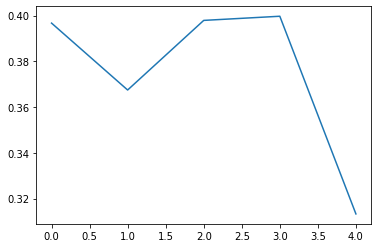

In [32]:
x_train = train.drop(["Sentiment"],axis=1)
y_train = train[['Sentiment']]

params = {
    "od_type":"Iter",
    "od_wait":150,
    "iterations":25000,
    'learning_rate':0.0355,
    "eval_metric":"Accuracy",
    "task_type":"GPU",
    # "boosting_type":"Plain"
}

best_score = np.inf
scores = []

kf = KFold(n_splits=5,shuffle=True,random_state=1250)

for train_idx , test_idx in kf.split(x_train,y_train):
  train_set = (x_train.iloc[train_idx],y_train.iloc[train_idx])
  test_set = (x_train.iloc[test_idx],y_train.iloc[test_idx])

  model = CatBoostClassifier(**params)
  model.fit(*train_set,
            cat_features = ['product'],
            eval_set=[test_set],early_stopping_rounds=500,verbose=200)

  score = log_loss(test_set[1].values,model.predict_proba(test_set[0]))
  print(score)
  scores.append(score)
  

  if score < best_score:
    best_score = score
    best_model = model

  print("-"*150)

print(f"Mean Score : {np.array(scores).mean()}")
print(f"Min Score : {np.array(scores).min()}")
print(f"Max Score : {np.array(scores).max()}")

plt.plot(scores)
plt.show()

model_base = best_model

In [33]:
submission_base = pd.DataFrame(model_base.predict_proba(test))
submission_base.columns = [f'Class_{i}' for i in submission_base.columns]
submission_base

,Class_0,Class_1,Class_2,Class_3
0,0.002744,0.050912,0.031902,0.914443
1,0.014622,0.027844,0.931766,0.025768
2,0.013976,0.010337,0.925876,0.049811
3,0.001267,0.010223,0.005660,0.982850
4,0.008717,0.002462,0.974155,0.014666
...,...,...,...,...
2723,0.026310,0.012768,0.914884,0.046038
2724,0.010783,0.004201,0.947652,0.037364
2725,0.000682,0.006713,0.023365,0.969240
2726,0.007149,0.002989,0.958203,0.031659


## Ensembling 

In [34]:
final_pred=(submission+submission_base)/2
final_pred

,Class_0,Class_1,Class_2,Class_3
0,0.002251,0.034428,0.035479,0.927842
1,0.019141,0.024917,0.928993,0.026948
2,0.012260,0.007354,0.939747,0.040639
3,0.001110,0.010936,0.005808,0.982146
4,0.008617,0.002457,0.967695,0.021231
...,...,...,...,...
2723,0.022439,0.017676,0.922452,0.037433
2724,0.010109,0.003766,0.945391,0.040734
2725,0.001226,0.014897,0.027846,0.956031
2726,0.009338,0.003771,0.957525,0.029366
